t = 0.00, max(dVdt) = -0.0407, max(dPdt) = 2.1457, max(dDdt) = 2.9781
t = 0.03, max(dVdt) = -0.0397, max(dPdt) = 2.1571, max(dDdt) = 3.8477
t = 0.00, max(dVdt) = -0.0406, max(dPdt) = 2.1461, max(dDdt) = 2.9800
t = 0.00, max(dVdt) = -0.0406, max(dPdt) = 2.1463, max(dDdt) = 2.9809
t = 0.01, max(dVdt) = -0.0404, max(dPdt) = 2.1483, max(dDdt) = 3.0654
t = 0.01, max(dVdt) = -0.0403, max(dPdt) = 2.1541, max(dDdt) = 3.0430
t = 0.01, max(dVdt) = -0.0403, max(dPdt) = 2.1610, max(dDdt) = 3.0747
t = 0.01, max(dVdt) = -0.0403, max(dPdt) = 2.1585, max(dDdt) = 3.1338
t = 0.00, max(dVdt) = -0.0406, max(dPdt) = 2.1461, max(dDdt) = 2.9797
t = 0.00, max(dVdt) = -0.0406, max(dPdt) = 2.1462, max(dDdt) = 2.9805
t = 0.01, max(dVdt) = -0.0404, max(dPdt) = 2.1472, max(dDdt) = 3.0418
t = 0.01, max(dVdt) = -0.0404, max(dPdt) = 2.1471, max(dDdt) = 3.0353
t = 0.01, max(dVdt) = -0.0404, max(dPdt) = 2.1517, max(dDdt) = 3.0631
t = 0.01, max(dVdt) = -0.0404, max(dPdt) = 2.1505, max(dDdt) = 3.0994
t = 0.01, max(dVdt) 

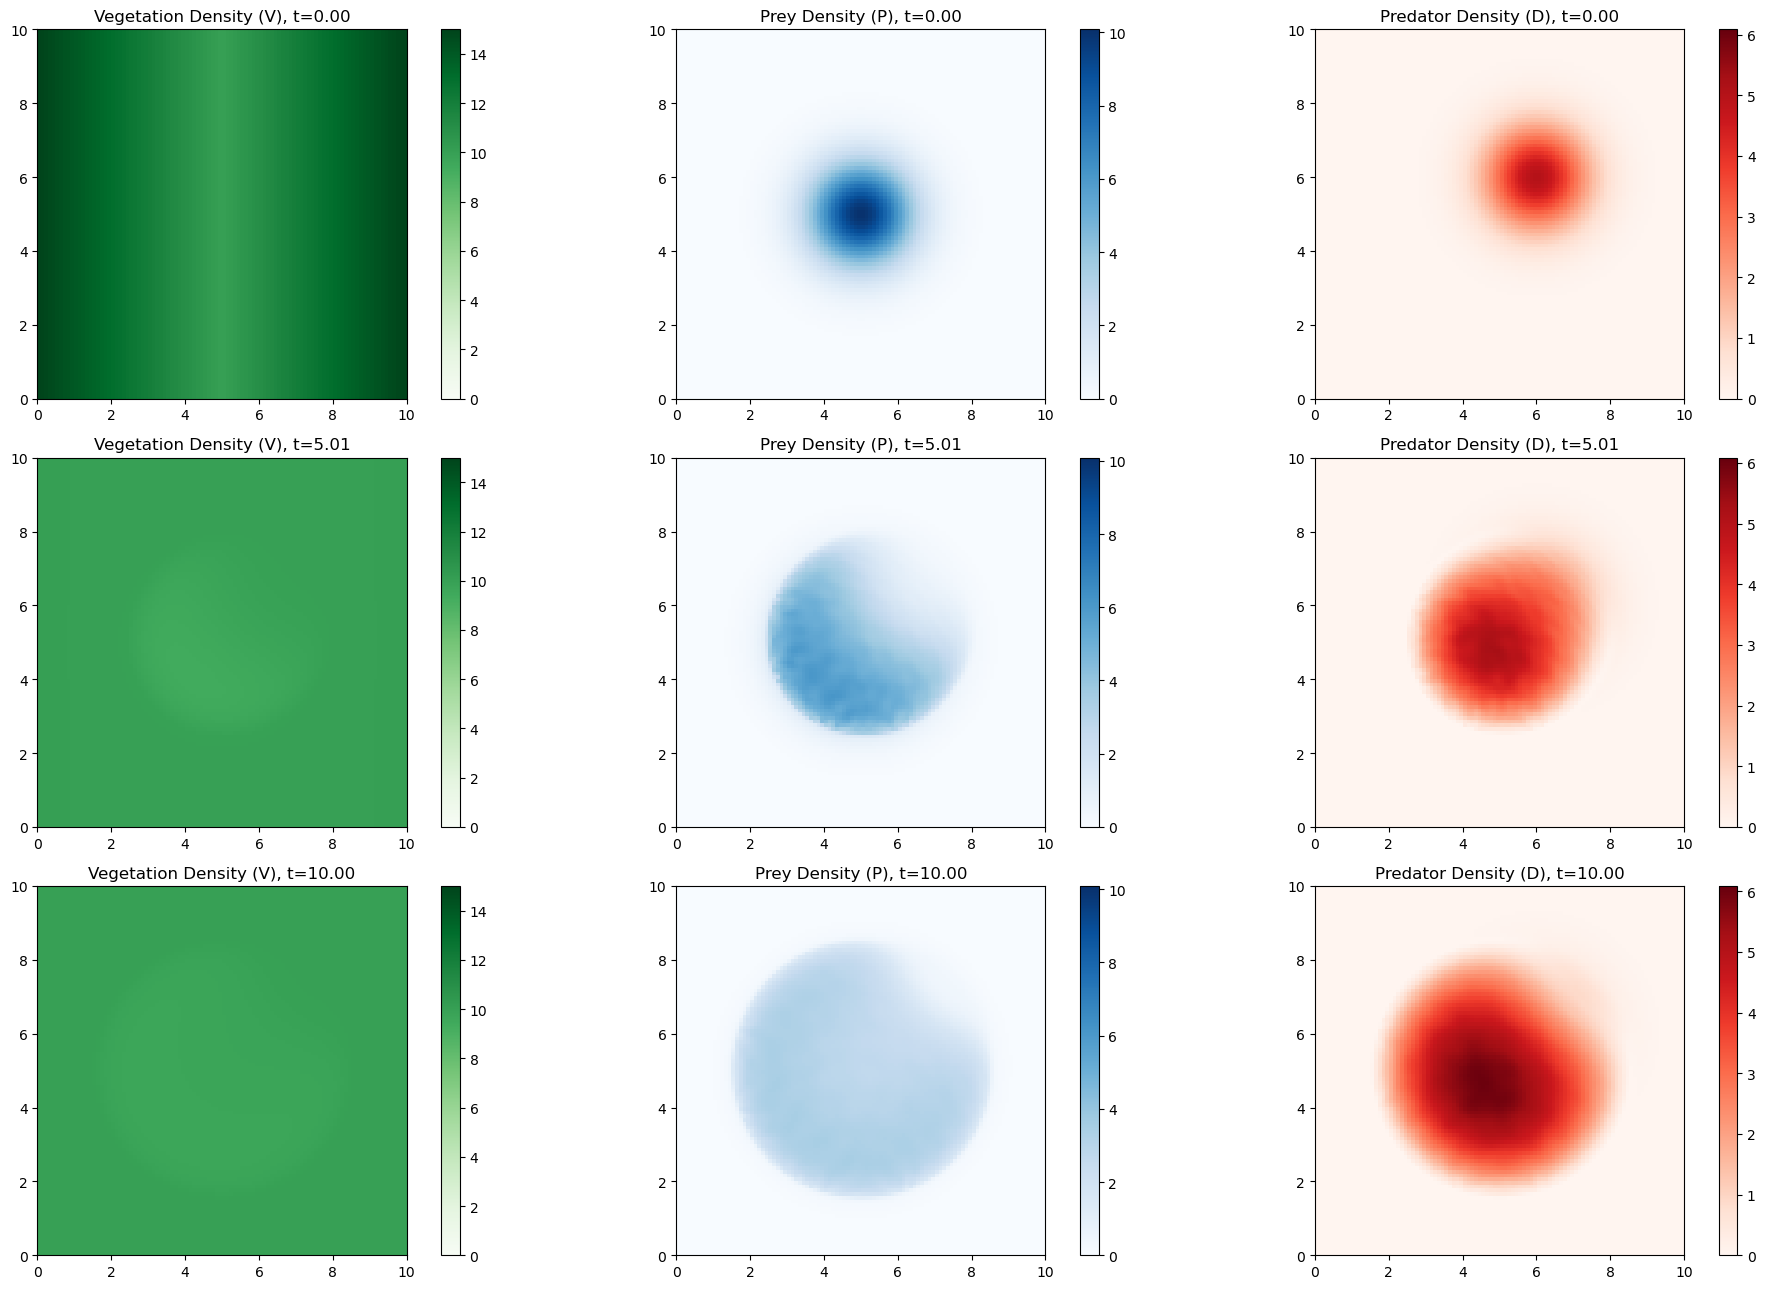

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define constants
params = {
    'alpha': 1.0,  # Tasa de crecimiento de la vegetación
    'beta': 0.01,  # Tasa de consumo de vegetación por las presas
    'gamma': 0.1,  # Tasa de saturación de vegetación
    'delta': 0.02, # Tasa de reproducción de presas por vegetación
    'epsilon': 0.03, # Tasa de depredación de presas
    'zeta': 0.015,  # Tasa de reproducción de depredadores por presas
    'eta': 0.01,    # Tasa de muerte de depredadores
    'theta': 0.02,  # Coeficiente de interacción espacial presa-vegetación
    'iota': 0.05,   # Coeficiente de interacción espacial presa-depredador
    'kappa': 0.05,  # Coeficiente de interacción espacial depredador-presa
    'Dv': 0.001,    # Coeficiente de difusión para vegetación
    'Dp': 0.005,    # Coeficiente de difusión para presas
    'Dd': 0.005     # Coeficiente de difusión para depredadores
}

# Define the spatial grid
nx, ny = 100, 100  # Grid size
Lx, Ly = 10.0, 10.0  # Physical dimensions of the domain
dx, dy = Lx / nx, Ly / ny  # Grid spacing

x, y = np.linspace(0, Lx, nx), np.linspace(0, Ly, ny)
x, y = np.meshgrid(x, y)

V0 = params['alpha'] / params['gamma'] * (np.ones((nx, ny)) + 0.1 * np.abs(x - 5))
P0 = 10 * np.exp(-((x - 5)**2 + (y - 5)**2) / 2.0)  # Localized prey population
D0 = 5 * np.exp(-((x - 6)**2 + (y - 6)**2) / 2.0)   # Localized predator population

# Laplacian function
def laplacian(Z, dx, dy):
    Zx = (np.roll(Z, -1, axis=0) - 2 * Z + np.roll(Z, 1, axis=0)) / dx**2
    Zy = (np.roll(Z, -1, axis=1) - 2 * Z + np.roll(Z, 1, axis=1)) / dy**2
    return Zx + Zy

# System of equations
def system(t, y, params, nx, ny, dx, dy):
    V = y[:nx*ny].reshape((nx, ny))
    P = y[nx*ny:2*nx*ny].reshape((nx, ny))
    D = y[2*nx*ny:].reshape((nx, ny))

    # Retrieve parameters
    alpha, beta, gamma = params['alpha'], params['beta'], params['gamma']
    delta, epsilon, zeta, eta = params['delta'], params['epsilon'], params['zeta'], params['eta']
    theta, iota, kappa = params['theta'], params['iota'], params['kappa']
    Dv, Dp, Dd = params['Dv'], params['Dp'], params['Dd']

    # Equations
    gradP = np.gradient(P)
    gradV = np.gradient(V)
    gradD = np.gradient(D)

    dVdt = V * (alpha - beta * P - gamma * V) + Dv * laplacian(V, dx, dy)
    dPdt = (P * (delta * V - epsilon * D) - theta * (P * laplacian(V, dx, dy) + gradP[0] * gradV[0] + gradP[1] * gradV[1]) + iota * (P * laplacian(D, dx, dy) + gradP[0] * gradD[0] + gradP[1] * gradD[1]) + Dp * laplacian(P, dx, dy))
    dDdt = (D * (zeta * P - eta) - kappa * (D * laplacian(P, dx, dy) + gradD[0] * gradP[0] + gradD[1] * gradP[1]) + Dd * laplacian(D, dx, dy))

    # Debugging: Print max values
    print(f"t = {t:.2f}, max(dVdt) = {np.max(dVdt):.4f}, max(dPdt) = {np.max(dPdt):.4f}, max(dDdt) = {np.max(dDdt):.4f}")

    return np.concatenate([dVdt.ravel(), dPdt.ravel(), dDdt.ravel()])

# Flatten initial conditions
y0 = np.concatenate([V0.ravel(), P0.ravel(), D0.ravel()])

T_max = 10

# Time integration
time_span = (0, T_max)  # Time range for simulation
time_eval = np.linspace(0, T_max, 100 * T_max)  # Time points to evaluate

solution = solve_ivp(
    system,
    time_span,
    y0,
    args=(params, nx, ny, dx, dy),
    t_eval=time_eval,
    method='RK45',  # Use a stiff solver
    atol=1e-8,     # Absolute tolerance
    rtol=1e-8      # Relative tolerance
)

# Reshape results
V = solution.y[:nx*ny, :].reshape((nx, ny, -1))
P = solution.y[nx*ny:2*nx*ny, :].reshape((nx, ny, -1))
D = solution.y[2*nx*ny:, :].reshape((nx, ny, -1))

# Plot results
vmin_V, vmax_V = 0.0, V.max()  # Vegetation density range
vmin_P, vmax_P = 0.0, P.max()  # Prey density range
vmin_D, vmax_D = 0.0, D.max()  # Predator density range

# Plot results for different time steps
N_steps = 2
steps = np.concatenate((np.array(np.linspace(0, N_steps-1, N_steps)*len(time_eval)//N_steps, dtype=int), [-1]))
plt.figure(figsize=(20, 5*N_steps+3))

for i, step in enumerate(steps):
    plt.subplot(len(steps), 3, i * 3 + 1)
    plt.title(f'Vegetation Density (V), t={solution.t[step]:.2f}')
    plt.imshow(V[:, :, step], extent=[0, Lx, 0, Ly], origin='lower', cmap='Greens', vmin=vmin_V, vmax=vmax_V)
    plt.colorbar()

    plt.subplot(len(steps), 3, i * 3 + 2)
    plt.title(f'Prey Density (P), t={time_eval[step]:.2f}')
    plt.imshow(P[:, :, step], extent=[0, Lx, 0, Ly], origin='lower', cmap='Blues', vmin=vmin_P, vmax=vmax_P)
    plt.colorbar()

    plt.subplot(len(steps), 3, i * 3 + 3)
    plt.title(f'Predator Density (D), t={time_eval[step]:.2f}')
    plt.imshow(D[:, :, step], extent=[0, Lx, 0, Ly], origin='lower', cmap='Reds', vmin=vmin_D, vmax=vmax_D)
    plt.colorbar()

plt.tight_layout()
plt.show()